In [5]:
%load_ext autoreload
%autoreload 2

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load dataset

## Create functions 
- create functions to load dataset and extract target labels (names)
- move functions to `src/data/dataset.py`

Example:
```python
def get_dataset() -> pd.DataFrame:
    """Read dataset into pandas.DataFrame
    
    Returns:
        pandas.DataFrame
    """
    
    data = load_iris(as_frame=True)
    
    dataset = data.frame
    dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

    return dataset


def get_target_names() -> List:
    return load_iris(as_frame=True).target_names.tolist()

```

## Import functions

In [6]:
from src.data.dataset import get_dataset,  get_target_names

dataset = get_dataset()

print(dataset.shape)
dataset.head()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# Feature names

feature_names = dataset.columns.tolist()[:4]
feature_names 

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [8]:
# Iris species

species = get_target_names()
species

['setosa', 'versicolor', 'virginica']

# Features engineering

## Create functions 
- create & move extract_features() into `src/features/features.py`

Example:
```python
def extract_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract features.

    Args:
        df {pandas.DataFrame}: dataset

    Returns:
        pandas.DataFrame: updated dataset with new features
    """

    dataset = df.copy()
    dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
    dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']


    dataset = dataset[[
        'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
        'sepal_length_to_sepal_width', 'petal_length_to_petal_width',

        'target'
    ]]

    return dataset
```

## Import functions

In [9]:
from src.features.features import extract_features

dataset = extract_features(dataset)
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


# Split dataset

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.3
random_state = 42

In [11]:
train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=42)
train_dataset.shape, test_dataset.shape

((105, 7), (45, 7))

# Train

## Create functions 
- create & move `train_lr()` into `src/train/train.py`


Example: 

```python
def train_lr(df: pd.DataFrame, target_column: Text) -> LogisticRegression:
    
    # Get X and Y
    y_train = df.loc[:, target_column].values.astype('int32')
    X_train = df.drop(target_column, axis=1).values.astype('float32')

    # Create an instance of Logistic Regression Classifier CV and fit the data

    logreg = LogisticRegression(C=0.001, solver='lbfgs', multi_class='multinomial', max_iter=100)
    logreg.fit(X_train, y_train)

    return logreg

```

## Import functions

In [12]:
from src.train.train import train_lr

model = train_lr(
    df = train_dataset,
    target_column = 'target'
)

In [13]:
model

LogisticRegression(C=0.001, multi_class='multinomial')


# Evaluate


## Create functions 
- move `evaluate()` to `src/evaluate/evaluate.py`
- move `plot_confusion_matrix()` to `src/report/visualize.py`

Example:

```python
def evaluate(df: pd.DataFrame, target_column: Text, clf: BaseEstimator) -> Dict:
    """Evaluate classifier on a dataset

    Args:
        df {pandas.DataFrame}: dataset
        target_column {Text}: target column name
        clf {sklearn.base.BaseEstimator}: classifier (trained model)

    Returns:
        Dict: Dict of reported metrics
            'f1' - F1 score
            'cm' - Comnfusion Matrix
            'actual' - true values for test data
            'predicted' - predicted values for test data
    """

    # Get X and Y
    y_test = df.loc[:, target_column].values.astype('int32')
    X_test = df.drop(target_column, axis=1).values.astype('float32')

    prediction = clf.predict(X_test)
    f1 = f1_score(y_true=y_test, y_pred=prediction, average='macro')
    cm = confusion_matrix(prediction, y_test)

    return {
        'f1': f1,
        'cm': cm,
        'actual': y_test,
        'predicted': prediction
    }
```


## Import functions 

In [17]:
from src.evaluate.evaluate import evaluate
from src.report.visualize import plot_confusion_matrix


report = evaluate(
    df = test_dataset,
    target_column = 'target',
    clf = model
)

f1 = report['f1']
cm = report['cm']

print(f1)
print(cm)

0.6348583877995643
[[15  0  0]
 [ 4  3  0]
 [ 0 10 13]]


In [18]:
report

{'f1': 0.6348583877995643,
 'cm': array([[15,  0,  0],
        [ 4,  3,  0],
        [ 0, 10, 13]]),
 'actual': array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
        0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
        0], dtype=int32),
 'predicted': array([2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 0, 2,
        1, 2, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 1,
        0], dtype=int32)}

<module 'matplotlib.pyplot' from '/home/alex/Dev/Projects/mlrepa/alex_kolosov/dvc-5-demo-project-iris/dvc-venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

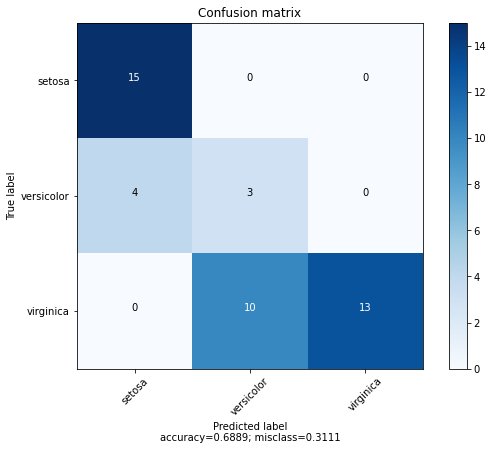

In [19]:
plot_confusion_matrix(cm, species, normalize=False)